# Resource allocation problem

Article: https://arxiv.org/abs/1806.09071 (in Russian)
How to find fair price?

### Case 1

$$
f(x_1,...,x_k) = \sum_{k=1}^n f_k(x_k) \to \min_{\sum\limits_{k=1}^n x_k = C}\quad (*)
$$

Let's consider $n$ factories with costs functions $f_k(x_k)$ --- the cost of production of amount $x$ of good by $k$-th factory. Assume that government need to buy quantity $C$ of this good per year. The goal of the government is to find such a price of the good $p$ that leads to the equality $\sum\limits_{k=1}^n x_k(p) = C$. Each year (iteration) the government put the price $p$ and obtain at the end of the year amount $\sum\limits_{k=1}^n x_k(p)$ of good, where $x_k(p)$ is an optimal level of developement of $k$-th factory when the price is $p$, that is 
$$
x_k(p)=\arg \max\limits_x \left\{px - f_k(x)\right\}.
$$
The strategy of the government is to rise price on the next year when $\sum\limits_{k=1}^n x_k < C$ and vice versa. The next text explain the best possible (up to an absolute multiplicatife constant) strategy of the government. 

$\textbf{Note 1:}$ The government doesn't need to know the functions $f_k(x_k)$ according to the described above strategy! Since that such a procedure can be fullfilled in centralized distributed manner (Nedic-Ozdaglar, 2009). That is each factory need to know from the government only the current price $p$ and return to the government only $x_k(p)$. There is no need to communicate with any other factories.   

$\textbf{Note 2:}$ The described above procedure converges to the equillibrium price $p_{*}$ with geometric rate of convergence. It's interesting to note, that vector $x_{*} = x(p_*)$ (calculated according to the equillibrium price) is a solution of the problem (*). This is true due to Lagrange multiplyers principle ($p$ is dual (Lagrange) multiplyer to the constraint $\sum\limits_{k=1}^n x_k = C$, we can also consider constrained $\sum\limits_{k=1}^n x_k >= C$, that guarantee $p \ge  0$).

In [1]:
import numpy as np
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt

In [2]:
def f(k, x):
    '''
    The cost function f_k(x_k)
    '''
    if k%2 == 1:
        return 0.5*x**4 + 0.5*x**2
    else: 
        return 2*x**2

def fsame(k, x):
    '''
    The cost function f_k(x_k)
    '''
    return 0.5*x**2    

def f1000(k, x):
    '''
    The cost function f_k(x_k)
    '''
    if k%2 == 1:
        return 4*x**4 + 2*x**2
    else: 
        return x**2 


def get_conj(k, p):
    '''
    The conjugate function of f(k, x). Was implemented by using the scipy minimize tools.
    '''
    lf = lambda x: -p*x + f(k, x) if x >= 0 and x<=C else np.inf # define the minus conjugate function with borders (0, C)
    return minimize_scalar(lf)['x'] 

def get_conj_same(k, p):
    '''
    The conjugate function of f(k, x). Was implemented by using the scipy minimize tools.
    '''
    lf = lambda x: -p*x + fsame(k, x) if x >= 0 and x<=C else np.inf # define the minus conjugate function with borders (0, C)
    return minimize_scalar(lf)['x'] 

def get_conj_1000(k, p):
    '''
    The conjugate function of f(k, x). Was implemented by using the scipy minimize tools.
    '''
    lf = lambda x: -p*x + f1000(k, x) if x >= 0 and x<=C else np.inf # define the minus conjugate function with borders (0, C)
    return minimize_scalar(lf)['x'] 

In [3]:
# Let's define the constant variables for problem 1
n = int(1e1) # number of factories
C = int(1e3) # Total budget
eps = 1e-4 # The desired precision

In [4]:
# Government price "tournament" procedure (based on dihotomy search rule)
def dihotomy(conj_func, a, b, epsilon):
    iterat = 0
    phi_values = []
    phi = np.inf # define the start error as infinity
    while abs(phi) > epsilon: 
        p = (a+b)/2 # re-define the price
        x = lambda k, p: conj_func(k, p) # calucate the x_k(p) -- as a function of two arguments
        phi = sum([x(k, p) for k in range(n)]) - C # compute the error function
        # here we will check the sign of it and move one of borders:
        if phi>0:
            b = (a + b)/2
        elif phi<0:
            a = (a + b)/2
        
        phi_values += [phi] # save phi, it need to plot as chart
        #print(p)
        iterat += 1
    return iterat, p, a, b, phi_values

In [5]:
p_min = 0 # left border of price
p_max = sum([f(k, 2*C/n) - f(k, 0) for k in range(n)])/C # calculate the right border of price
p = None # the p is undefined
N = 0

print('The same cost functions')
print('At the start:   N: {}, p: {}, p_min: {}, p_max: {}'.format(0, p, p_min, p_max))

N, p, p_min, p_max, phi_values = dihotomy(get_conj_same, p_min, p_max, eps)

print('At the end:     N: {}, p: {}, p_min: {}, p_max: {}'.format(N, p, p_min, p_max))
#print_values = [x(k, p) for k in range(n)]

The same cost functions
At the start:   N: 0, p: None, p_min: 0, p_max: 4000500.0
At the end:     N: 38, p: 100.00000309264578, p_min: 99.99998853891157, p_max: 100.00000309264578


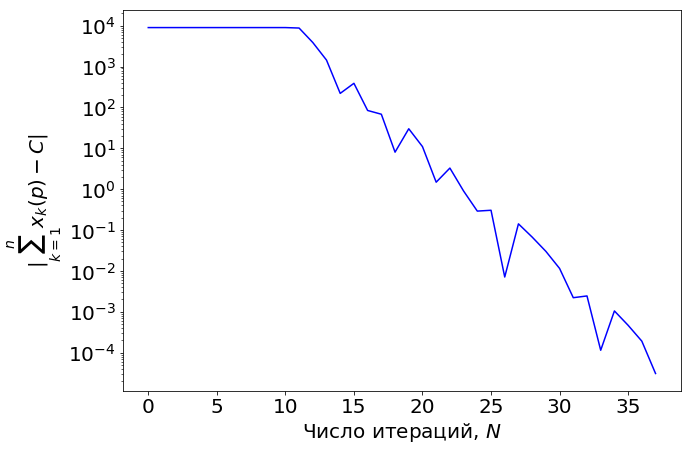

In [6]:
formula = r'$ \left | \sum_{k=1}^n x_k(p)-C \right | $' # y label

fig = plt.figure(figsize=(10, 7))
fig.add_subplot(111)
plt.yscale('log')
plt.plot(np.arange(N), [abs(el) for el in phi_values], c='blue')
plt.xlabel('Число итераций, $N$', fontsize=20)
plt.ylabel(formula, fontsize=20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.savefig('plot1.png')
plt.show()

In [7]:
# Let's define the constant variables for problem 2
n = int(1e2) # number of factories
C = int(1e4) # Total budget
eps = 1e-4 # The desired precision

In [8]:
p_min = 0 # left border of price
p_max = sum([f(k, 2*C/n) - f(k, 0) for k in range(n)])/C # calculate the right border of price
p = None # the p is undefined
N = 0

print('Different cost functions')
print('At the start:   N: {}, p: {}, p_min: {}, p_max: {}'.format(0, p, p_min, p_max))

N, p, p_min, p_max, phi_values = dihotomy(get_conj, p_min, p_max, eps)

print('At the end:     N: {}, p: {}, p_min: {}, p_max: {}'.format(N, p, p_min, p_max))

Different cost functions
At the start:   N: 0, p: None, p_min: 0, p_max: 4000500.0
At the end:     N: 35, p: 770.9801115706796, p_min: 770.9801115706796, p_max: 770.9802280005533


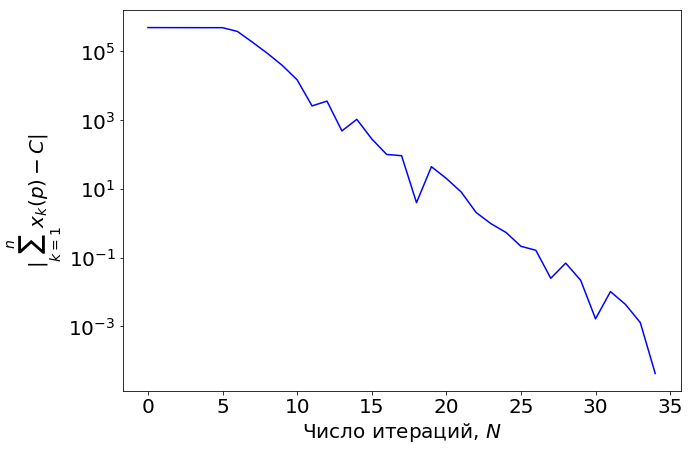

In [9]:
formula = r'$\vert\sum_{k=1}^n x_k(p) - C \vert$' # y label

fig = plt.figure(figsize=(10, 7))
fig.add_subplot(111)
plt.yscale('log')
plt.plot(np.arange(N), [abs(el) for el in phi_values], c='blue')
plt.xlabel('Число итераций, $N$', fontsize=20)
plt.ylabel(formula, fontsize=20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.savefig('plot2.png')
plt.show()

In [10]:
# Let's define the constant variables for problem 3
n = int(1e3) # number of factories
C = int(1e6) # Total budget
eps = 1e-4 # The desired precision

In [11]:
p_min = 0 # left border of price
p_max = sum([f(k, 2*C/n) - f(k, 0) for k in range(n)])/C # calculate the right border of price
p = None # the p is undefined
N = 0

print('Problem 3 --- 1000 factories')
print('At the start:   N: {}, p: {}, p_min: {}, p_max: {}'.format(0, p, p_min, p_max))

N, p, p_min, p_max, phi_values = dihotomy(get_conj_1000, p_min, p_max, eps)

print('At the end:     N: {}, p: {}, p_min: {}, p_max: {}'.format(N, p, p_min, p_max))

Problem 3 --- 1000 factories
At the start:   N: 0, p: None, p_min: 0, p_max: 4000005000.0
At the end:     N: 52, p: 3987.440474532418, p_min: 3987.440473644239, p_max: 3987.440474532418


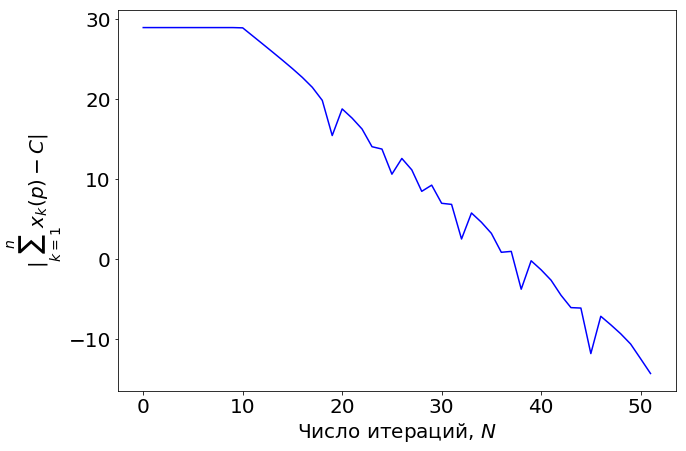

In [12]:
formula = r'$\vert\sum_{k=1}^n x_k(p) - C \vert$' # y label

fig = plt.figure(figsize=(10, 7))
fig.add_subplot(111)
plt.plot(np.arange(N), [np.log2(abs(el)) for el in phi_values], c = 'blue')
plt.xlabel('Число итераций, $N$', fontsize=20)
plt.ylabel(formula, fontsize=20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.savefig('plot3.png')
plt.show()

### Case 2

Государство больше не контролирует цены на рынке. Каждое предприятие вправе устанавливать свою цену на пшеницу. Каждое предприятие устанавливает цену на пшеницу $p_k$ и определяет, сколько тонн пшеницы
оно произведёт ($x_k$), стараясь максимизировать прибыль. Затем государство сравнивает
цены предприяний и определяет $y_k$~--- количество, которое оно покупает у $k$-го предприятия (при этом государству по-прежнему важно закупить определённое количество
пшеницы). Далее предприятия сравнивают, насколько и как отличается $x_k$ от $y_k$ (то есть,
насколько их ''предложение'' отличается от ''спроса'' государства непосредственно на их
товар), и на основе этого корректируют цену на пшеницу.

In [13]:
def f(k, x):
    '''
    The cost function f_k(x_k)
    '''
    return 0.5*x**2
    
def get_conj(k, p):
    '''
    The conjugate function of f(k, x). Was implemented by using the scipy minimize tools.
    '''    
    lf = lambda x: -p*x+f(k, x) if x >= 0 and x<=C else np.inf
    return minimize_scalar(lf, bounds=(0, C))['x']

def grad(lam, x):
    '''
    Subgradient of function \phi
    '''
    return x - C*lam

def get_argmin_indicies(a):
    '''
    Implementation of finding the Argmin set. 
    '''
    return np.where(a==min(a))[0] # we use np.where() method to find all indicies of values of list a equals to min(a)

In [14]:
# Let's define the constant variables for this problem...

C = 1000  # Total budget
eps = 10**(-1) # The desired precision

n = 10 # The number of factories (developers)

In [15]:
x_tmp = [2*C / n for k in range(n)] # Initial x

p_max = (sum([f(k, x_tmp[k]) - f(k, 0) for k in range(n)])) / C # right border of price

# Here we calculate the h

R = p_max/np.sqrt(n) 
M = C*np.sqrt(n)
N = int(9*R**2*M**2/eps**2)

print('p_max: {}\nN: {}'.format(p_max, N))

h = 3*R/(M*np.sqrt(N)) # step
print('h: {}'.format(h))

p_max: 200.0
N: 36000000000000
h: 9.999999999999999e-09


In [ ]:
# Lets restrict the number of iteration. It is nessesary, because the convergence of duality gap is actually slow
# but the N is much more bigger than our restiction max_size
max_size = int(5e8)

In [ ]:
%%time
file = open('./log.txt', 'w+') # file which is used to write logs
gap_save = [] # gaps on each iteration
x_save = [] # x on each iteration
p_save = [] # price on each iteration
t = 0 # iteration number  
gap = np.inf # initial gap
condition = np.inf # the value of second condition in the theorem
p = np.zeros(n) # initial price is equal all zeros
p_save += [p.copy()] 
x_N, p_N = 0, 0 # initial value of x_N, p_N (look the theorem)
while (t < max_size)&((gap>eps)|(condition>eps/p_max)): # all theorem conditions should be keeped
    x = np.array([get_conj(k, p[k]) for k in range(n)]) # calculate the list of values x-function
    x_save += [x.copy()] # save it

    lambd = np.zeros(n) # define the lambda
    indicies = get_argmin_indicies(p) # find the Argmin(p)
    lambd[indicies] = 1/indicies.shape[0] # define the lambda according to theorem's definition
    p = p-h*grad(lambd, x) # adjust the price
    p = p*(p>0).astype(int) # and make a positive
    p_save += [p.copy()] # save it
    
    f_sum = lambda el: np.sum([f(k, el[k]) for k in range(n)]) # function which compute the sum of all cost function 
                                                               # in the previous iterations
    phi = lambda el: np.sum([el[k]*x[k] - f(k, x[k]) for k in range(n)]) - C*min(el) # phi function (see the paper)
    x_N = (x_N*t+x_save[t])/(t+1) # adjust x_N from the last iteration (it is adjust for cumulative sum of previous values)
    p_N = (p_N*t+p_save[t])/(t+1) # adjust p_N from the last iteration (it is adjust for cumulative sum of previous values)

    gap = abs(f_sum(x_N) + phi(p_N)) # compute the duality gap
    condition = abs(C-np.sum(x_N)) # compute the value of the second condition on the theorem
    gap_save += [gap.copy()] # save the value of gap
    
    # here we will verbose logs each 500 iterations
    if t%500 == 0 or t==max_size-1: 
        file.write('{} {} {}\n'.format(t, p[0], gap))

    # here we will verbose progress to stdout each 10000 iterations
    if t%10000==0:
        print('Iteration [{}: {}/{}], gap is {}, condition is {} and p[0] is equal to {}'\
               .format(t/max_size, t, max_size, np.round(gap, 3), np.round(condition, 3), np.round(p[0], 3)))
    t += 1
file.close()

C:\Users\Jane\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:1927: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


Iteration [0.0%: 0/500000000], gap is 0.0, condition is 1000.0 and p[0] is equal to 0.0
Iteration [2e-05%: 10000/500000000], gap is 5.0, condition is 999.95 and p[0] is equal to 0.01
Iteration [4e-05%: 20000/500000000], gap is 9.999, condition is 999.9 and p[0] is equal to 0.02
Iteration [6e-05%: 30000/500000000], gap is 14.997, condition is 999.85 and p[0] is equal to 0.03
Iteration [8e-05%: 40000/500000000], gap is 19.995, condition is 999.8 and p[0] is equal to 0.04
Iteration [0.0001%: 50000/500000000], gap is 24.993, condition is 999.75 and p[0] is equal to 0.05
Iteration [0.00012%: 60000/500000000], gap is 29.99, condition is 999.7 and p[0] is equal to 0.06
Iteration [0.00014%: 70000/500000000], gap is 34.986, condition is 999.65 and p[0] is equal to 0.07
Iteration [0.00016%: 80000/500000000], gap is 39.981, condition is 999.6 and p[0] is equal to 0.08
Iteration [0.00018%: 90000/500000000], gap is 44.976, condition is 999.55 and p[0] is equal to 0.09
Iteration [0.0002%: 100000/500

Iteration [0.00162%: 810000/500000000], gap is 403.089, condition is 995.961 and p[0] is equal to 0.807
Iteration [0.00164%: 820000/500000000], gap is 408.041, condition is 995.911 and p[0] is equal to 0.817
Iteration [0.00166%: 830000/500000000], gap is 412.993, condition is 995.861 and p[0] is equal to 0.827
Iteration [0.00168%: 840000/500000000], gap is 417.944, condition is 995.812 and p[0] is equal to 0.836
Iteration [0.0017%: 850000/500000000], gap is 422.895, condition is 995.762 and p[0] is equal to 0.846
Iteration [0.00172%: 860000/500000000], gap is 427.846, condition is 995.712 and p[0] is equal to 0.856
Iteration [0.00174%: 870000/500000000], gap is 432.795, condition is 995.663 and p[0] is equal to 0.866
Iteration [0.00176%: 880000/500000000], gap is 437.744, condition is 995.613 and p[0] is equal to 0.876
Iteration [0.00178%: 890000/500000000], gap is 442.693, condition is 995.563 and p[0] is equal to 0.886
Iteration [0.0018%: 900000/500000000], gap is 447.641, condition 

Iteration [0.0032%: 1600000/500000000], gap is 792.551, condition is 992.042 and p[0] is equal to 1.587
Iteration [0.00322%: 1610000/500000000], gap is 797.457, condition is 991.993 and p[0] is equal to 1.597
Iteration [0.00324%: 1620000/500000000], gap is 802.363, condition is 991.944 and p[0] is equal to 1.607
Iteration [0.00326%: 1630000/500000000], gap is 807.269, condition is 991.894 and p[0] is equal to 1.617
Iteration [0.00328%: 1640000/500000000], gap is 812.174, condition is 991.845 and p[0] is equal to 1.627
Iteration [0.0033%: 1650000/500000000], gap is 817.078, condition is 991.795 and p[0] is equal to 1.636
Iteration [0.00332%: 1660000/500000000], gap is 821.982, condition is 991.746 and p[0] is equal to 1.646
Iteration [0.00334%: 1670000/500000000], gap is 826.885, condition is 991.696 and p[0] is equal to 1.656
Iteration [0.00336%: 1680000/500000000], gap is 831.788, condition is 991.647 and p[0] is equal to 1.666
Iteration [0.00338%: 1690000/500000000], gap is 836.69, c

Iteration [0.00478%: 2390000/500000000], gap is 1178.398, condition is 988.145 and p[0] is equal to 2.362
Iteration [0.0048%: 2400000/500000000], gap is 1183.259, condition is 988.095 and p[0] is equal to 2.371
Iteration [0.00482%: 2410000/500000000], gap is 1188.119, condition is 988.046 and p[0] is equal to 2.381
Iteration [0.00484%: 2420000/500000000], gap is 1192.979, condition is 987.997 and p[0] is equal to 2.391
Iteration [0.00486%: 2430000/500000000], gap is 1197.839, condition is 987.948 and p[0] is equal to 2.401
Iteration [0.00488%: 2440000/500000000], gap is 1202.697, condition is 987.899 and p[0] is equal to 2.41
Iteration [0.0049%: 2450000/500000000], gap is 1207.555, condition is 987.849 and p[0] is equal to 2.42
Iteration [0.00492%: 2460000/500000000], gap is 1212.413, condition is 987.8 and p[0] is equal to 2.43
Iteration [0.00494%: 2470000/500000000], gap is 1217.27, condition is 987.751 and p[0] is equal to 2.44
Iteration [0.00496%: 2480000/500000000], gap is 1222.12

Iteration [0.00634%: 3170000/500000000], gap is 1555.827, condition is 984.316 and p[0] is equal to 3.12
Iteration [0.00636%: 3180000/500000000], gap is 1560.644, condition is 984.267 and p[0] is equal to 3.13
Iteration [0.00638%: 3190000/500000000], gap is 1565.459, condition is 984.218 and p[0] is equal to 3.14
Iteration [0.0064%: 3200000/500000000], gap is 1570.274, condition is 984.169 and p[0] is equal to 3.149
Iteration [0.00642%: 3210000/500000000], gap is 1575.088, condition is 984.12 and p[0] is equal to 3.159
Iteration [0.00644%: 3220000/500000000], gap is 1579.902, condition is 984.071 and p[0] is equal to 3.169
Iteration [0.00646%: 3230000/500000000], gap is 1584.715, condition is 984.022 and p[0] is equal to 3.178
Iteration [0.00648%: 3240000/500000000], gap is 1589.528, condition is 983.974 and p[0] is equal to 3.188
Iteration [0.0065%: 3250000/500000000], gap is 1594.34, condition is 983.925 and p[0] is equal to 3.198
Iteration [0.00652%: 3260000/500000000], gap is 1599.

Iteration [0.0079%: 3950000/500000000], gap is 1929.759, condition is 980.507 and p[0] is equal to 3.873
Iteration [0.00792%: 3960000/500000000], gap is 1934.53, condition is 980.459 and p[0] is equal to 3.883
Iteration [0.00794%: 3970000/500000000], gap is 1939.301, condition is 980.41 and p[0] is equal to 3.892
Iteration [0.00796%: 3980000/500000000], gap is 1944.071, condition is 980.361 and p[0] is equal to 3.902
Iteration [0.00798%: 3990000/500000000], gap is 1948.841, condition is 980.313 and p[0] is equal to 3.911
Iteration [0.008%: 4000000/500000000], gap is 1953.61, condition is 980.264 and p[0] is equal to 3.921
Iteration [0.00802%: 4010000/500000000], gap is 1958.378, condition is 980.215 and p[0] is equal to 3.931
Iteration [0.00804%: 4020000/500000000], gap is 1963.146, condition is 980.167 and p[0] is equal to 3.94
Iteration [0.00806%: 4030000/500000000], gap is 1967.914, condition is 980.118 and p[0] is equal to 3.95
Iteration [0.00808%: 4040000/500000000], gap is 1972.6

Iteration [0.00946%: 4730000/500000000], gap is 2300.206, condition is 976.719 and p[0] is equal to 4.62
Iteration [0.00948%: 4740000/500000000], gap is 2304.933, condition is 976.67 and p[0] is equal to 4.629
Iteration [0.0095%: 4750000/500000000], gap is 2309.659, condition is 976.622 and p[0] is equal to 4.639
Iteration [0.00952%: 4760000/500000000], gap is 2314.385, condition is 976.573 and p[0] is equal to 4.648
Iteration [0.00954%: 4770000/500000000], gap is 2319.11, condition is 976.525 and p[0] is equal to 4.658
Iteration [0.00956%: 4780000/500000000], gap is 2323.834, condition is 976.476 and p[0] is equal to 4.668
Iteration [0.00958%: 4790000/500000000], gap is 2328.558, condition is 976.428 and p[0] is equal to 4.677
Iteration [0.0096%: 4800000/500000000], gap is 2333.281, condition is 976.379 and p[0] is equal to 4.687
Iteration [0.00962%: 4810000/500000000], gap is 2338.004, condition is 976.331 and p[0] is equal to 4.696
Iteration [0.00964%: 4820000/500000000], gap is 234

Iteration [0.01102%: 5510000/500000000], gap is 2667.182, condition is 972.949 and p[0] is equal to 5.361
Iteration [0.01104%: 5520000/500000000], gap is 2671.864, condition is 972.901 and p[0] is equal to 5.37
Iteration [0.01106%: 5530000/500000000], gap is 2676.546, condition is 972.853 and p[0] is equal to 5.38
Iteration [0.01108%: 5540000/500000000], gap is 2681.227, condition is 972.805 and p[0] is equal to 5.389
Iteration [0.0111%: 5550000/500000000], gap is 2685.908, condition is 972.756 and p[0] is equal to 5.399
Iteration [0.01112%: 5560000/500000000], gap is 2690.588, condition is 972.708 and p[0] is equal to 5.408
Iteration [0.01114%: 5570000/500000000], gap is 2695.268, condition is 972.66 and p[0] is equal to 5.418
Iteration [0.01116%: 5580000/500000000], gap is 2699.947, condition is 972.612 and p[0] is equal to 5.427
Iteration [0.01118%: 5590000/500000000], gap is 2704.625, condition is 972.564 and p[0] is equal to 5.437
Iteration [0.0112%: 5600000/500000000], gap is 270

Iteration [0.01258%: 6290000/500000000], gap is 3030.701, condition is 969.199 and p[0] is equal to 6.096
Iteration [0.0126%: 6300000/500000000], gap is 3035.339, condition is 969.151 and p[0] is equal to 6.106
Iteration [0.01262%: 6310000/500000000], gap is 3039.977, condition is 969.103 and p[0] is equal to 6.115
Iteration [0.01264%: 6320000/500000000], gap is 3044.614, condition is 969.055 and p[0] is equal to 6.124
Iteration [0.01266%: 6330000/500000000], gap is 3049.25, condition is 969.007 and p[0] is equal to 6.134
Iteration [0.01268%: 6340000/500000000], gap is 3053.886, condition is 968.959 and p[0] is equal to 6.143
Iteration [0.0127%: 6350000/500000000], gap is 3058.522, condition is 968.912 and p[0] is equal to 6.153
Iteration [0.01272%: 6360000/500000000], gap is 3063.156, condition is 968.864 and p[0] is equal to 6.162
Iteration [0.01274%: 6370000/500000000], gap is 3067.79, condition is 968.816 and p[0] is equal to 6.171
Iteration [0.01276%: 6380000/500000000], gap is 30

Iteration [0.01414%: 7070000/500000000], gap is 3390.778, condition is 965.469 and p[0] is equal to 6.826
Iteration [0.01416%: 7080000/500000000], gap is 3395.372, condition is 965.421 and p[0] is equal to 6.835
Iteration [0.01418%: 7090000/500000000], gap is 3399.965, condition is 965.373 and p[0] is equal to 6.844
Iteration [0.0142%: 7100000/500000000], gap is 3404.558, condition is 965.325 and p[0] is equal to 6.854
Iteration [0.01422%: 7110000/500000000], gap is 3409.151, condition is 965.278 and p[0] is equal to 6.863
Iteration [0.01424%: 7120000/500000000], gap is 3413.743, condition is 965.23 and p[0] is equal to 6.872
Iteration [0.01426%: 7130000/500000000], gap is 3418.334, condition is 965.182 and p[0] is equal to 6.882
Iteration [0.01428%: 7140000/500000000], gap is 3422.925, condition is 965.135 and p[0] is equal to 6.891
Iteration [0.0143%: 7150000/500000000], gap is 3427.515, condition is 965.087 and p[0] is equal to 6.9
Iteration [0.01432%: 7160000/500000000], gap is 343

Iteration [0.0157%: 7850000/500000000], gap is 3747.426, condition is 961.757 and p[0] is equal to 7.55
Iteration [0.01572%: 7860000/500000000], gap is 3751.976, condition is 961.71 and p[0] is equal to 7.559
Iteration [0.01574%: 7870000/500000000], gap is 3756.526, condition is 961.662 and p[0] is equal to 7.568
Iteration [0.01576%: 7880000/500000000], gap is 3761.075, condition is 961.615 and p[0] is equal to 7.578
Iteration [0.01578%: 7890000/500000000], gap is 3765.624, condition is 961.567 and p[0] is equal to 7.587
Iteration [0.0158%: 7900000/500000000], gap is 3770.172, condition is 961.52 and p[0] is equal to 7.596
Iteration [0.01582%: 7910000/500000000], gap is 3774.719, condition is 961.473 and p[0] is equal to 7.605
Iteration [0.01584%: 7920000/500000000], gap is 3779.266, condition is 961.425 and p[0] is equal to 7.614
Iteration [0.01586%: 7930000/500000000], gap is 3783.812, condition is 961.378 and p[0] is equal to 7.624
Iteration [0.01588%: 7940000/500000000], gap is 378

Iteration [0.01726%: 8630000/500000000], gap is 4100.661, condition is 958.065 and p[0] is equal to 8.268
Iteration [0.01728%: 8640000/500000000], gap is 4105.168, condition is 958.018 and p[0] is equal to 8.277
Iteration [0.0173%: 8650000/500000000], gap is 4109.674, condition is 957.971 and p[0] is equal to 8.286
Iteration [0.01732%: 8660000/500000000], gap is 4114.179, condition is 957.923 and p[0] is equal to 8.296
Iteration [0.01734%: 8670000/500000000], gap is 4118.684, condition is 957.876 and p[0] is equal to 8.305
Iteration [0.01736%: 8680000/500000000], gap is 4123.188, condition is 957.829 and p[0] is equal to 8.314
Iteration [0.01738%: 8690000/500000000], gap is 4127.692, condition is 957.782 and p[0] is equal to 8.323
Iteration [0.0174%: 8700000/500000000], gap is 4132.195, condition is 957.735 and p[0] is equal to 8.332
Iteration [0.01742%: 8710000/500000000], gap is 4136.698, condition is 957.687 and p[0] is equal to 8.341
Iteration [0.01744%: 8720000/500000000], gap is 

Iteration [0.01882%: 9410000/500000000], gap is 4450.498, condition is 954.392 and p[0] is equal to 8.981
Iteration [0.01884%: 9420000/500000000], gap is 4454.961, condition is 954.345 and p[0] is equal to 8.99
Iteration [0.01886%: 9430000/500000000], gap is 4459.423, condition is 954.298 and p[0] is equal to 8.999
Iteration [0.01888%: 9440000/500000000], gap is 4463.885, condition is 954.251 and p[0] is equal to 9.008
Iteration [0.0189%: 9450000/500000000], gap is 4468.347, condition is 954.204 and p[0] is equal to 9.017
Iteration [0.01892%: 9460000/500000000], gap is 4472.808, condition is 954.157 and p[0] is equal to 9.026
Iteration [0.01894%: 9470000/500000000], gap is 4477.268, condition is 954.11 and p[0] is equal to 9.035
Iteration [0.01896%: 9480000/500000000], gap is 4481.728, condition is 954.063 and p[0] is equal to 9.045
Iteration [0.01898%: 9490000/500000000], gap is 4486.187, condition is 954.016 and p[0] is equal to 9.054
Iteration [0.019%: 9500000/500000000], gap is 449

Iteration [0.02038%: 10190000/500000000], gap is 4796.951, condition is 950.737 and p[0] is equal to 9.688
Iteration [0.0204%: 10200000/500000000], gap is 4801.371, condition is 950.691 and p[0] is equal to 9.697
Iteration [0.02042%: 10210000/500000000], gap is 4805.79, condition is 950.644 and p[0] is equal to 9.706
Iteration [0.02044%: 10220000/500000000], gap is 4810.209, condition is 950.597 and p[0] is equal to 9.715
Iteration [0.02046%: 10230000/500000000], gap is 4814.627, condition is 950.551 and p[0] is equal to 9.724
Iteration [0.02048%: 10240000/500000000], gap is 4819.045, condition is 950.504 and p[0] is equal to 9.733
Iteration [0.0205%: 10250000/500000000], gap is 4823.462, condition is 950.457 and p[0] is equal to 9.742
Iteration [0.02052%: 10260000/500000000], gap is 4827.878, condition is 950.41 and p[0] is equal to 9.751
Iteration [0.02054%: 10270000/500000000], gap is 4832.294, condition is 950.364 and p[0] is equal to 9.76
Iteration [0.02056%: 10280000/500000000], 

Iteration [0.02192%: 10960000/500000000], gap is 5135.66, condition is 947.148 and p[0] is equal to 10.381
Iteration [0.02194%: 10970000/500000000], gap is 5140.037, condition is 947.102 and p[0] is equal to 10.39
Iteration [0.02196%: 10980000/500000000], gap is 5144.414, condition is 947.055 and p[0] is equal to 10.399
Iteration [0.02198%: 10990000/500000000], gap is 5148.79, condition is 947.009 and p[0] is equal to 10.408
Iteration [0.022%: 11000000/500000000], gap is 5153.166, condition is 946.962 and p[0] is equal to 10.417
Iteration [0.02202%: 11010000/500000000], gap is 5157.541, condition is 946.916 and p[0] is equal to 10.426
Iteration [0.02204%: 11020000/500000000], gap is 5161.915, condition is 946.869 and p[0] is equal to 10.435
Iteration [0.02206%: 11030000/500000000], gap is 5166.289, condition is 946.823 and p[0] is equal to 10.443
Iteration [0.02208%: 11040000/500000000], gap is 5170.663, condition is 946.777 and p[0] is equal to 10.452
Iteration [0.0221%: 11050000/5000

Iteration [0.02346%: 11730000/500000000], gap is 5471.102, condition is 943.578 and p[0] is equal to 11.068
Iteration [0.02348%: 11740000/500000000], gap is 5475.437, condition is 943.531 and p[0] is equal to 11.077
Iteration [0.0235%: 11750000/500000000], gap is 5479.771, condition is 943.485 and p[0] is equal to 11.086
Iteration [0.02352%: 11760000/500000000], gap is 5484.105, condition is 943.439 and p[0] is equal to 11.095
Iteration [0.02354%: 11770000/500000000], gap is 5488.438, condition is 943.393 and p[0] is equal to 11.104
Iteration [0.02356%: 11780000/500000000], gap is 5492.771, condition is 943.346 and p[0] is equal to 11.113
Iteration [0.02358%: 11790000/500000000], gap is 5497.103, condition is 943.3 and p[0] is equal to 11.122
Iteration [0.0236%: 11800000/500000000], gap is 5501.435, condition is 943.254 and p[0] is equal to 11.13
Iteration [0.02362%: 11810000/500000000], gap is 5505.766, condition is 943.208 and p[0] is equal to 11.139
Iteration [0.02364%: 11820000/500

Iteration [0.025%: 12500000/500000000], gap is 5803.292, condition is 940.025 and p[0] is equal to 11.75
Iteration [0.02502%: 12510000/500000000], gap is 5807.585, condition is 939.979 and p[0] is equal to 11.759
Iteration [0.02504%: 12520000/500000000], gap is 5811.877, condition is 939.933 and p[0] is equal to 11.768
Iteration [0.02506%: 12530000/500000000], gap is 5816.169, condition is 939.887 and p[0] is equal to 11.777
Iteration [0.02508%: 12540000/500000000], gap is 5820.46, condition is 939.841 and p[0] is equal to 11.786
Iteration [0.0251%: 12550000/500000000], gap is 5824.751, condition is 939.795 and p[0] is equal to 11.794
Iteration [0.02512%: 12560000/500000000], gap is 5829.041, condition is 939.749 and p[0] is equal to 11.803
Iteration [0.02514%: 12570000/500000000], gap is 5833.331, condition is 939.703 and p[0] is equal to 11.812
Iteration [0.02516%: 12580000/500000000], gap is 5837.62, condition is 939.657 and p[0] is equal to 11.821
Iteration [0.02518%: 12590000/5000

Iteration [0.02654%: 13270000/500000000], gap is 6132.247, condition is 936.49 and p[0] is equal to 12.427
Iteration [0.02656%: 13280000/500000000], gap is 6136.498, condition is 936.444 and p[0] is equal to 12.436
Iteration [0.02658%: 13290000/500000000], gap is 6140.748, condition is 936.398 and p[0] is equal to 12.445
Iteration [0.0266%: 13300000/500000000], gap is 6144.998, condition is 936.353 and p[0] is equal to 12.453
Iteration [0.02662%: 13310000/500000000], gap is 6149.247, condition is 936.307 and p[0] is equal to 12.462
Iteration [0.02664%: 13320000/500000000], gap is 6153.496, condition is 936.261 and p[0] is equal to 12.471
Iteration [0.02666%: 13330000/500000000], gap is 6157.744, condition is 936.215 and p[0] is equal to 12.48
Iteration [0.02668%: 13340000/500000000], gap is 6161.992, condition is 936.17 and p[0] is equal to 12.489
Iteration [0.0267%: 13350000/500000000], gap is 6166.239, condition is 936.124 and p[0] is equal to 12.497
Iteration [0.02672%: 13360000/500

Iteration [0.02808%: 14040000/500000000], gap is 6457.981, condition is 932.973 and p[0] is equal to 13.099
Iteration [0.0281%: 14050000/500000000], gap is 6462.19, condition is 932.928 and p[0] is equal to 13.108
Iteration [0.02812%: 14060000/500000000], gap is 6466.399, condition is 932.882 and p[0] is equal to 13.116
Iteration [0.02814%: 14070000/500000000], gap is 6470.607, condition is 932.837 and p[0] is equal to 13.125
Iteration [0.02816%: 14080000/500000000], gap is 6474.815, condition is 932.791 and p[0] is equal to 13.134
Iteration [0.02818%: 14090000/500000000], gap is 6479.022, condition is 932.745 and p[0] is equal to 13.142
Iteration [0.0282%: 14100000/500000000], gap is 6483.228, condition is 932.7 and p[0] is equal to 13.151
Iteration [0.02822%: 14110000/500000000], gap is 6487.434, condition is 932.654 and p[0] is equal to 13.16
Iteration [0.02824%: 14120000/500000000], gap is 6491.64, condition is 932.609 and p[0] is equal to 13.168
Iteration [0.02826%: 14130000/50000

Iteration [0.02962%: 14810000/500000000], gap is 6780.511, condition is 929.474 and p[0] is equal to 13.766
Iteration [0.02964%: 14820000/500000000], gap is 6784.679, condition is 929.429 and p[0] is equal to 13.774
Iteration [0.02966%: 14830000/500000000], gap is 6788.846, condition is 929.384 and p[0] is equal to 13.783
Iteration [0.02968%: 14840000/500000000], gap is 6793.013, condition is 929.338 and p[0] is equal to 13.791
Iteration [0.0297%: 14850000/500000000], gap is 6797.179, condition is 929.293 and p[0] is equal to 13.8
Iteration [0.02972%: 14860000/500000000], gap is 6801.344, condition is 929.248 and p[0] is equal to 13.809
Iteration [0.02974%: 14870000/500000000], gap is 6805.509, condition is 929.202 and p[0] is equal to 13.817
Iteration [0.02976%: 14880000/500000000], gap is 6809.674, condition is 929.157 and p[0] is equal to 13.826
Iteration [0.02978%: 14890000/500000000], gap is 6813.838, condition is 929.112 and p[0] is equal to 13.834
Iteration [0.0298%: 14900000/50

Iteration [0.03116%: 15580000/500000000], gap is 7099.853, condition is 925.993 and p[0] is equal to 14.427
Iteration [0.03118%: 15590000/500000000], gap is 7103.979, condition is 925.948 and p[0] is equal to 14.436
Iteration [0.0312%: 15600000/500000000], gap is 7108.105, condition is 925.903 and p[0] is equal to 14.444
Iteration [0.03122%: 15610000/500000000], gap is 7112.231, condition is 925.858 and p[0] is equal to 14.453
Iteration [0.03124%: 15620000/500000000], gap is 7116.355, condition is 925.812 and p[0] is equal to 14.461
Iteration [0.03126%: 15630000/500000000], gap is 7120.48, condition is 925.767 and p[0] is equal to 14.47
Iteration [0.03128%: 15640000/500000000], gap is 7124.603, condition is 925.722 and p[0] is equal to 14.478
Iteration [0.0313%: 15650000/500000000], gap is 7128.727, condition is 925.677 and p[0] is equal to 14.487
Iteration [0.03132%: 15660000/500000000], gap is 7132.849, condition is 925.632 and p[0] is equal to 14.495
Iteration [0.03134%: 15670000/50

Iteration [0.0327%: 16350000/500000000], gap is 7416.023, condition is 922.529 and p[0] is equal to 15.083
Iteration [0.03272%: 16360000/500000000], gap is 7420.108, condition is 922.484 and p[0] is equal to 15.092
Iteration [0.03274%: 16370000/500000000], gap is 7424.193, condition is 922.439 and p[0] is equal to 15.1
Iteration [0.03276%: 16380000/500000000], gap is 7428.277, condition is 922.394 and p[0] is equal to 15.109
Iteration [0.03278%: 16390000/500000000], gap is 7432.361, condition is 922.35 and p[0] is equal to 15.117
Iteration [0.0328%: 16400000/500000000], gap is 7436.444, condition is 922.305 and p[0] is equal to 15.126
Iteration [0.03282%: 16410000/500000000], gap is 7440.527, condition is 922.26 and p[0] is equal to 15.134
Iteration [0.03284%: 16420000/500000000], gap is 7444.609, condition is 922.215 and p[0] is equal to 15.143
Iteration [0.03286%: 16430000/500000000], gap is 7448.69, condition is 922.17 and p[0] is equal to 15.151
Iteration [0.03288%: 16440000/500000

Iteration [0.03424%: 17120000/500000000], gap is 7729.037, condition is 919.083 and p[0] is equal to 15.735
Iteration [0.03426%: 17130000/500000000], gap is 7733.081, condition is 919.038 and p[0] is equal to 15.743
Iteration [0.03428%: 17140000/500000000], gap is 7737.125, condition is 918.994 and p[0] is equal to 15.752
Iteration [0.0343%: 17150000/500000000], gap is 7741.169, condition is 918.949 and p[0] is equal to 15.76
Iteration [0.03432%: 17160000/500000000], gap is 7745.211, condition is 918.904 and p[0] is equal to 15.768
Iteration [0.03434%: 17170000/500000000], gap is 7749.254, condition is 918.86 and p[0] is equal to 15.777
Iteration [0.03436%: 17180000/500000000], gap is 7753.295, condition is 918.815 and p[0] is equal to 15.785
Iteration [0.03438%: 17190000/500000000], gap is 7757.337, condition is 918.77 and p[0] is equal to 15.794
Iteration [0.0344%: 17200000/500000000], gap is 7761.377, condition is 918.726 and p[0] is equal to 15.802
Iteration [0.03442%: 17210000/500

Iteration [0.03578%: 17890000/500000000], gap is 8038.912, condition is 915.654 and p[0] is equal to 16.381
Iteration [0.0358%: 17900000/500000000], gap is 8042.915, condition is 915.61 and p[0] is equal to 16.389
Iteration [0.03582%: 17910000/500000000], gap is 8046.919, condition is 915.565 and p[0] is equal to 16.398
Iteration [0.03584%: 17920000/500000000], gap is 8050.921, condition is 915.521 and p[0] is equal to 16.406
Iteration [0.03586%: 17930000/500000000], gap is 8054.924, condition is 915.476 and p[0] is equal to 16.414
Iteration [0.03588%: 17940000/500000000], gap is 8058.925, condition is 915.432 and p[0] is equal to 16.423
Iteration [0.0359%: 17950000/500000000], gap is 8062.926, condition is 915.387 and p[0] is equal to 16.431
Iteration [0.03592%: 17960000/500000000], gap is 8066.927, condition is 915.343 and p[0] is equal to 16.44
Iteration [0.03594%: 17970000/500000000], gap is 8070.927, condition is 915.299 and p[0] is equal to 16.448
Iteration [0.03596%: 17980000/50

Iteration [0.03732%: 18660000/500000000], gap is 8345.664, condition is 912.242 and p[0] is equal to 17.022
Iteration [0.03734%: 18670000/500000000], gap is 8349.627, condition is 912.198 and p[0] is equal to 17.031
Iteration [0.03736%: 18680000/500000000], gap is 8353.59, condition is 912.154 and p[0] is equal to 17.039
Iteration [0.03738%: 18690000/500000000], gap is 8357.552, condition is 912.11 and p[0] is equal to 17.047
Iteration [0.0374%: 18700000/500000000], gap is 8361.514, condition is 912.066 and p[0] is equal to 17.056
Iteration [0.03742%: 18710000/500000000], gap is 8365.475, condition is 912.021 and p[0] is equal to 17.064
Iteration [0.03744%: 18720000/500000000], gap is 8369.436, condition is 911.977 and p[0] is equal to 17.072
Iteration [0.03746%: 18730000/500000000], gap is 8373.396, condition is 911.933 and p[0] is equal to 17.081
Iteration [0.03748%: 18740000/500000000], gap is 8377.356, condition is 911.889 and p[0] is equal to 17.089
Iteration [0.0375%: 18750000/50

Iteration [0.03886%: 19430000/500000000], gap is 8649.311, condition is 908.848 and p[0] is equal to 17.659
Iteration [0.03888%: 19440000/500000000], gap is 8653.234, condition is 908.804 and p[0] is equal to 17.667
Iteration [0.0389%: 19450000/500000000], gap is 8657.156, condition is 908.76 and p[0] is equal to 17.675
Iteration [0.03892%: 19460000/500000000], gap is 8661.078, condition is 908.716 and p[0] is equal to 17.684
Iteration [0.03894%: 19470000/500000000], gap is 8665.0, condition is 908.672 and p[0] is equal to 17.692
Iteration [0.03896%: 19480000/500000000], gap is 8668.921, condition is 908.628 and p[0] is equal to 17.7
Iteration [0.03898%: 19490000/500000000], gap is 8672.841, condition is 908.584 and p[0] is equal to 17.708
Iteration [0.039%: 19500000/500000000], gap is 8676.761, condition is 908.54 and p[0] is equal to 17.717
Iteration [0.03902%: 19510000/500000000], gap is 8680.681, condition is 908.496 and p[0] is equal to 17.725
Iteration [0.03904%: 19520000/5000000

Iteration [0.0404%: 20200000/500000000], gap is 8949.868, condition is 905.471 and p[0] is equal to 18.291
Iteration [0.04042%: 20210000/500000000], gap is 8953.751, condition is 905.427 and p[0] is equal to 18.299
Iteration [0.04044%: 20220000/500000000], gap is 8957.634, condition is 905.383 and p[0] is equal to 18.307
Iteration [0.04046%: 20230000/500000000], gap is 8961.516, condition is 905.339 and p[0] is equal to 18.315
Iteration [0.04048%: 20240000/500000000], gap is 8965.398, condition is 905.296 and p[0] is equal to 18.323
Iteration [0.0405%: 20250000/500000000], gap is 8969.279, condition is 905.252 and p[0] is equal to 18.331
Iteration [0.04052%: 20260000/500000000], gap is 8973.159, condition is 905.208 and p[0] is equal to 18.34
Iteration [0.04054%: 20270000/500000000], gap is 8977.039, condition is 905.164 and p[0] is equal to 18.348
Iteration [0.04056%: 20280000/500000000], gap is 8980.919, condition is 905.121 and p[0] is equal to 18.356
Iteration [0.04058%: 20290000/5

Iteration [0.04194%: 20970000/500000000], gap is 9247.354, condition is 902.11 and p[0] is equal to 18.917
Iteration [0.04196%: 20980000/500000000], gap is 9251.198, condition is 902.067 and p[0] is equal to 18.925
Iteration [0.04198%: 20990000/500000000], gap is 9255.04, condition is 902.023 and p[0] is equal to 18.933
Iteration [0.042%: 21000000/500000000], gap is 9258.883, condition is 901.98 and p[0] is equal to 18.942
Iteration [0.04202%: 21010000/500000000], gap is 9262.725, condition is 901.936 and p[0] is equal to 18.95
Iteration [0.04204%: 21020000/500000000], gap is 9266.566, condition is 901.893 and p[0] is equal to 18.958
Iteration [0.04206%: 21030000/500000000], gap is 9270.407, condition is 901.849 and p[0] is equal to 18.966
Iteration [0.04208%: 21040000/500000000], gap is 9274.247, condition is 901.806 and p[0] is equal to 18.974
Iteration [0.0421%: 21050000/500000000], gap is 9278.087, condition is 901.762 and p[0] is equal to 18.982
Iteration [0.04212%: 21060000/50000

Iteration [0.04348%: 21740000/500000000], gap is 9541.786, condition is 898.767 and p[0] is equal to 19.539
Iteration [0.0435%: 21750000/500000000], gap is 9545.589, condition is 898.724 and p[0] is equal to 19.547
Iteration [0.04352%: 21760000/500000000], gap is 9549.393, condition is 898.68 and p[0] is equal to 19.555
Iteration [0.04354%: 21770000/500000000], gap is 9553.195, condition is 898.637 and p[0] is equal to 19.563
Iteration [0.04356%: 21780000/500000000], gap is 9556.998, condition is 898.594 and p[0] is equal to 19.571
Iteration [0.04358%: 21790000/500000000], gap is 9560.799, condition is 898.55 and p[0] is equal to 19.579
Iteration [0.0436%: 21800000/500000000], gap is 9564.601, condition is 898.507 and p[0] is equal to 19.587
Iteration [0.04362%: 21810000/500000000], gap is 9568.401, condition is 898.464 and p[0] is equal to 19.595
Iteration [0.04364%: 21820000/500000000], gap is 9572.202, condition is 898.421 and p[0] is equal to 19.604
Iteration [0.04366%: 21830000/50

Iteration [0.04502%: 22510000/500000000], gap is 9833.18, condition is 895.44 and p[0] is equal to 20.156
Iteration [0.04504%: 22520000/500000000], gap is 9836.944, condition is 895.397 and p[0] is equal to 20.164
Iteration [0.04506%: 22530000/500000000], gap is 9840.708, condition is 895.354 and p[0] is equal to 20.172
Iteration [0.04508%: 22540000/500000000], gap is 9844.471, condition is 895.311 and p[0] is equal to 20.18
Iteration [0.0451%: 22550000/500000000], gap is 9848.234, condition is 895.268 and p[0] is equal to 20.188
Iteration [0.04512%: 22560000/500000000], gap is 9851.997, condition is 895.225 and p[0] is equal to 20.196
Iteration [0.04514%: 22570000/500000000], gap is 9855.759, condition is 895.182 and p[0] is equal to 20.204
Iteration [0.04516%: 22580000/500000000], gap is 9859.52, condition is 895.139 and p[0] is equal to 20.212
Iteration [0.04518%: 22590000/500000000], gap is 9863.281, condition is 895.096 and p[0] is equal to 20.22
Iteration [0.0452%: 22600000/50000

Iteration [0.04654%: 23270000/500000000], gap is 10117.828, condition is 892.173 and p[0] is equal to 20.761
Iteration [0.04656%: 23280000/500000000], gap is 10121.554, condition is 892.13 and p[0] is equal to 20.769
Iteration [0.04658%: 23290000/500000000], gap is 10125.279, condition is 892.088 and p[0] is equal to 20.777
Iteration [0.0466%: 23300000/500000000], gap is 10129.004, condition is 892.045 and p[0] is equal to 20.785
Iteration [0.04662%: 23310000/500000000], gap is 10132.728, condition is 892.002 and p[0] is equal to 20.793
Iteration [0.04664%: 23320000/500000000], gap is 10136.452, condition is 891.959 and p[0] is equal to 20.8
Iteration [0.04666%: 23330000/500000000], gap is 10140.175, condition is 891.916 and p[0] is equal to 20.808
Iteration [0.04668%: 23340000/500000000], gap is 10143.898, condition is 891.873 and p[0] is equal to 20.816
Iteration [0.0467%: 23350000/500000000], gap is 10147.62, condition is 891.83 and p[0] is equal to 20.824
Iteration [0.04672%: 23360

Iteration [0.04806%: 24030000/500000000], gap is 10399.551, condition is 888.923 and p[0] is equal to 21.361
Iteration [0.04808%: 24040000/500000000], gap is 10403.238, condition is 888.88 and p[0] is equal to 21.369
Iteration [0.0481%: 24050000/500000000], gap is 10406.925, condition is 888.837 and p[0] is equal to 21.377
Iteration [0.04812%: 24060000/500000000], gap is 10410.612, condition is 888.795 and p[0] is equal to 21.384
Iteration [0.04814%: 24070000/500000000], gap is 10414.298, condition is 888.752 and p[0] is equal to 21.392
Iteration [0.04816%: 24080000/500000000], gap is 10417.983, condition is 888.709 and p[0] is equal to 21.4
Iteration [0.04818%: 24090000/500000000], gap is 10421.668, condition is 888.667 and p[0] is equal to 21.408
Iteration [0.0482%: 24100000/500000000], gap is 10425.352, condition is 888.624 and p[0] is equal to 21.416
Iteration [0.04822%: 24110000/500000000], gap is 10429.036, condition is 888.581 and p[0] is equal to 21.424
Iteration [0.04824%: 241

Iteration [0.04958%: 24790000/500000000], gap is 10678.365, condition is 885.688 and p[0] is equal to 21.956
Iteration [0.0496%: 24800000/500000000], gap is 10682.015, condition is 885.645 and p[0] is equal to 21.964
Iteration [0.04962%: 24810000/500000000], gap is 10685.663, condition is 885.603 and p[0] is equal to 21.972
Iteration [0.04964%: 24820000/500000000], gap is 10689.312, condition is 885.56 and p[0] is equal to 21.98
Iteration [0.04966%: 24830000/500000000], gap is 10692.96, condition is 885.518 and p[0] is equal to 21.987
Iteration [0.04968%: 24840000/500000000], gap is 10696.607, condition is 885.476 and p[0] is equal to 21.995
Iteration [0.0497%: 24850000/500000000], gap is 10700.254, condition is 885.433 and p[0] is equal to 22.003
Iteration [0.04972%: 24860000/500000000], gap is 10703.9, condition is 885.391 and p[0] is equal to 22.011
Iteration [0.04974%: 24870000/500000000], gap is 10707.546, condition is 885.348 and p[0] is equal to 22.019
Iteration [0.04976%: 24880

Iteration [0.0511%: 25550000/500000000], gap is 10954.288, condition is 882.469 and p[0] is equal to 22.547
Iteration [0.05112%: 25560000/500000000], gap is 10957.9, condition is 882.427 and p[0] is equal to 22.555
Iteration [0.05114%: 25570000/500000000], gap is 10961.511, condition is 882.385 and p[0] is equal to 22.563
Iteration [0.05116%: 25580000/500000000], gap is 10965.121, condition is 882.342 and p[0] is equal to 22.57
Iteration [0.05118%: 25590000/500000000], gap is 10968.731, condition is 882.3 and p[0] is equal to 22.578
Iteration [0.0512%: 25600000/500000000], gap is 10972.34, condition is 882.258 and p[0] is equal to 22.586
Iteration [0.05122%: 25610000/500000000], gap is 10975.949, condition is 882.216 and p[0] is equal to 22.594
Iteration [0.05124%: 25620000/500000000], gap is 10979.558, condition is 882.173 and p[0] is equal to 22.601
Iteration [0.05126%: 25630000/500000000], gap is 10983.165, condition is 882.131 and p[0] is equal to 22.609
Iteration [0.05128%: 256400

Iteration [0.05262%: 26310000/500000000], gap is 11227.337, condition is 879.266 and p[0] is equal to 23.133
Iteration [0.05264%: 26320000/500000000], gap is 11230.911, condition is 879.224 and p[0] is equal to 23.141
Iteration [0.05266%: 26330000/500000000], gap is 11234.484, condition is 879.182 and p[0] is equal to 23.149
Iteration [0.05268%: 26340000/500000000], gap is 11238.057, condition is 879.14 and p[0] is equal to 23.157
Iteration [0.0527%: 26350000/500000000], gap is 11241.629, condition is 879.098 and p[0] is equal to 23.164
Iteration [0.05272%: 26360000/500000000], gap is 11245.201, condition is 879.056 and p[0] is equal to 23.172
Iteration [0.05274%: 26370000/500000000], gap is 11248.772, condition is 879.014 and p[0] is equal to 23.18
Iteration [0.05276%: 26380000/500000000], gap is 11252.342, condition is 878.972 and p[0] is equal to 23.187
Iteration [0.05278%: 26390000/500000000], gap is 11255.913, condition is 878.93 and p[0] is equal to 23.195
Iteration [0.0528%: 264

Iteration [0.05414%: 27070000/500000000], gap is 11497.529, condition is 876.079 and p[0] is equal to 23.715
Iteration [0.05416%: 27080000/500000000], gap is 11501.065, condition is 876.038 and p[0] is equal to 23.723
Iteration [0.05418%: 27090000/500000000], gap is 11504.6, condition is 875.996 and p[0] is equal to 23.731
Iteration [0.0542%: 27100000/500000000], gap is 11508.136, condition is 875.954 and p[0] is equal to 23.738
Iteration [0.05422%: 27110000/500000000], gap is 11511.67, condition is 875.912 and p[0] is equal to 23.746
Iteration [0.05424%: 27120000/500000000], gap is 11515.205, condition is 875.87 and p[0] is equal to 23.754
Iteration [0.05426%: 27130000/500000000], gap is 11518.738, condition is 875.828 and p[0] is equal to 23.761
Iteration [0.05428%: 27140000/500000000], gap is 11522.272, condition is 875.787 and p[0] is equal to 23.769
Iteration [0.0543%: 27150000/500000000], gap is 11525.804, condition is 875.745 and p[0] is equal to 23.776
Iteration [0.05432%: 2716

Iteration [0.05566%: 27830000/500000000], gap is 11764.88, condition is 872.908 and p[0] is equal to 24.293
Iteration [0.05568%: 27840000/500000000], gap is 11768.379, condition is 872.867 and p[0] is equal to 24.301
Iteration [0.0557%: 27850000/500000000], gap is 11771.877, condition is 872.825 and p[0] is equal to 24.308
Iteration [0.05572%: 27860000/500000000], gap is 11775.375, condition is 872.783 and p[0] is equal to 24.316
Iteration [0.05574%: 27870000/500000000], gap is 11778.873, condition is 872.742 and p[0] is equal to 24.323
Iteration [0.05576%: 27880000/500000000], gap is 11782.37, condition is 872.7 and p[0] is equal to 24.331
Iteration [0.05578%: 27890000/500000000], gap is 11785.866, condition is 872.658 and p[0] is equal to 24.338
Iteration [0.0558%: 27900000/500000000], gap is 11789.362, condition is 872.617 and p[0] is equal to 24.346
Iteration [0.05582%: 27910000/500000000], gap is 11792.858, condition is 872.575 and p[0] is equal to 24.354
Iteration [0.05584%: 2792

Iteration [0.05718%: 28590000/500000000], gap is 12029.409, condition is 869.753 and p[0] is equal to 24.866
Iteration [0.0572%: 28600000/500000000], gap is 12032.87, condition is 869.711 and p[0] is equal to 24.874
Iteration [0.05722%: 28610000/500000000], gap is 12036.332, condition is 869.67 and p[0] is equal to 24.881
Iteration [0.05724%: 28620000/500000000], gap is 12039.793, condition is 869.628 and p[0] is equal to 24.889
Iteration [0.05726%: 28630000/500000000], gap is 12043.253, condition is 869.587 and p[0] is equal to 24.896
Iteration [0.05728%: 28640000/500000000], gap is 12046.713, condition is 869.545 and p[0] is equal to 24.904
Iteration [0.0573%: 28650000/500000000], gap is 12050.173, condition is 869.504 and p[0] is equal to 24.911
Iteration [0.05732%: 28660000/500000000], gap is 12053.632, condition is 869.463 and p[0] is equal to 24.919
Iteration [0.05734%: 28670000/500000000], gap is 12057.09, condition is 869.421 and p[0] is equal to 24.926
Iteration [0.05736%: 286

Iteration [0.0587%: 29350000/500000000], gap is 12291.131, condition is 866.613 and p[0] is equal to 25.435
Iteration [0.05872%: 29360000/500000000], gap is 12294.557, condition is 866.571 and p[0] is equal to 25.443
Iteration [0.05874%: 29370000/500000000], gap is 12297.981, condition is 866.53 and p[0] is equal to 25.45
Iteration [0.05876%: 29380000/500000000], gap is 12301.405, condition is 866.489 and p[0] is equal to 25.457
Iteration [0.05878%: 29390000/500000000], gap is 12304.829, condition is 866.448 and p[0] is equal to 25.465
Iteration [0.0588%: 29400000/500000000], gap is 12308.252, condition is 866.406 and p[0] is equal to 25.472
Iteration [0.05882%: 29410000/500000000], gap is 12311.675, condition is 866.365 and p[0] is equal to 25.48
Iteration [0.05884%: 29420000/500000000], gap is 12315.097, condition is 866.324 and p[0] is equal to 25.487
Iteration [0.05886%: 29430000/500000000], gap is 12318.519, condition is 866.283 and p[0] is equal to 25.495
Iteration [0.05888%: 294

Iteration [0.06022%: 30110000/500000000], gap is 12550.066, condition is 863.488 and p[0] is equal to 26.0
Iteration [0.06024%: 30120000/500000000], gap is 12553.455, condition is 863.447 and p[0] is equal to 26.007
Iteration [0.06026%: 30130000/500000000], gap is 12556.843, condition is 863.406 and p[0] is equal to 26.014
Iteration [0.06028%: 30140000/500000000], gap is 12560.23, condition is 863.365 and p[0] is equal to 26.022
Iteration [0.0603%: 30150000/500000000], gap is 12563.618, condition is 863.324 and p[0] is equal to 26.029
Iteration [0.06032%: 30160000/500000000], gap is 12567.004, condition is 863.283 and p[0] is equal to 26.037
Iteration [0.06034%: 30170000/500000000], gap is 12570.39, condition is 863.242 and p[0] is equal to 26.044
Iteration [0.06036%: 30180000/500000000], gap is 12573.776, condition is 863.201 and p[0] is equal to 26.051
Iteration [0.06038%: 30190000/500000000], gap is 12577.161, condition is 863.16 and p[0] is equal to 26.059
Iteration [0.0604%: 30200

Iteration [0.06174%: 30870000/500000000], gap is 12806.23, condition is 860.379 and p[0] is equal to 26.56
Iteration [0.06176%: 30880000/500000000], gap is 12809.582, condition is 860.338 and p[0] is equal to 26.567
Iteration [0.06178%: 30890000/500000000], gap is 12812.934, condition is 860.297 and p[0] is equal to 26.575
Iteration [0.0618%: 30900000/500000000], gap is 12816.285, condition is 860.256 and p[0] is equal to 26.582
Iteration [0.06182%: 30910000/500000000], gap is 12819.636, condition is 860.216 and p[0] is equal to 26.589
Iteration [0.06184%: 30920000/500000000], gap is 12822.987, condition is 860.175 and p[0] is equal to 26.597
Iteration [0.06186%: 30930000/500000000], gap is 12826.336, condition is 860.134 and p[0] is equal to 26.604
Iteration [0.06188%: 30940000/500000000], gap is 12829.686, condition is 860.093 and p[0] is equal to 26.611
Iteration [0.0619%: 30950000/500000000], gap is 12833.034, condition is 860.052 and p[0] is equal to 26.619
Iteration [0.06192%: 30

Iteration [0.06326%: 31630000/500000000], gap is 13059.641, condition is 857.285 and p[0] is equal to 27.116
Iteration [0.06328%: 31640000/500000000], gap is 13062.957, condition is 857.244 and p[0] is equal to 27.123
Iteration [0.0633%: 31650000/500000000], gap is 13066.273, condition is 857.204 and p[0] is equal to 27.13
Iteration [0.06332%: 31660000/500000000], gap is 13069.588, condition is 857.163 and p[0] is equal to 27.138
Iteration [0.06334%: 31670000/500000000], gap is 13072.902, condition is 857.123 and p[0] is equal to 27.145
Iteration [0.06336%: 31680000/500000000], gap is 13076.217, condition is 857.082 and p[0] is equal to 27.152
Iteration [0.06338%: 31690000/500000000], gap is 13079.53, condition is 857.041 and p[0] is equal to 27.16
Iteration [0.0634%: 31700000/500000000], gap is 13082.844, condition is 857.001 and p[0] is equal to 27.167
Iteration [0.06342%: 31710000/500000000], gap is 13086.156, condition is 856.96 and p[0] is equal to 27.174
Iteration [0.06344%: 3172

Iteration [0.06478%: 32390000/500000000], gap is 13310.316, condition is 854.206 and p[0] is equal to 27.668
Iteration [0.0648%: 32400000/500000000], gap is 13313.596, condition is 854.166 and p[0] is equal to 27.675
Iteration [0.06482%: 32410000/500000000], gap is 13316.876, condition is 854.126 and p[0] is equal to 27.682
Iteration [0.06484%: 32420000/500000000], gap is 13320.155, condition is 854.085 and p[0] is equal to 27.689
Iteration [0.06486%: 32430000/500000000], gap is 13323.434, condition is 854.045 and p[0] is equal to 27.697
Iteration [0.06488%: 32440000/500000000], gap is 13326.712, condition is 854.004 and p[0] is equal to 27.704
Iteration [0.0649%: 32450000/500000000], gap is 13329.99, condition is 853.964 and p[0] is equal to 27.711
Iteration [0.06492%: 32460000/500000000], gap is 13333.267, condition is 853.924 and p[0] is equal to 27.718
Iteration [0.06494%: 32470000/500000000], gap is 13336.544, condition is 853.883 and p[0] is equal to 27.726
Iteration [0.06496%: 3

Iteration [0.0663%: 33150000/500000000], gap is 13558.272, condition is 851.143 and p[0] is equal to 28.215
Iteration [0.06632%: 33160000/500000000], gap is 13561.517, condition is 851.103 and p[0] is equal to 28.223
Iteration [0.06634%: 33170000/500000000], gap is 13564.761, condition is 851.062 and p[0] is equal to 28.23
Iteration [0.06636%: 33180000/500000000], gap is 13568.004, condition is 851.022 and p[0] is equal to 28.237
Iteration [0.06638%: 33190000/500000000], gap is 13571.248, condition is 850.982 and p[0] is equal to 28.244
Iteration [0.0664%: 33200000/500000000], gap is 13574.49, condition is 850.942 and p[0] is equal to 28.251
Iteration [0.06642%: 33210000/500000000], gap is 13577.733, condition is 850.902 and p[0] is equal to 28.258
Iteration [0.06644%: 33220000/500000000], gap is 13580.974, condition is 850.861 and p[0] is equal to 28.266
Iteration [0.06646%: 33230000/500000000], gap is 13584.215, condition is 850.821 and p[0] is equal to 28.273
Iteration [0.06648%: 33

Iteration [0.06782%: 33910000/500000000], gap is 13803.528, condition is 848.094 and p[0] is equal to 28.759
Iteration [0.06784%: 33920000/500000000], gap is 13806.737, condition is 848.054 and p[0] is equal to 28.766
Iteration [0.06786%: 33930000/500000000], gap is 13809.946, condition is 848.014 and p[0] is equal to 28.773
Iteration [0.06788%: 33940000/500000000], gap is 13813.154, condition is 847.974 and p[0] is equal to 28.78
Iteration [0.0679%: 33950000/500000000], gap is 13816.362, condition is 847.934 and p[0] is equal to 28.787
Iteration [0.06792%: 33960000/500000000], gap is 13819.569, condition is 847.894 and p[0] is equal to 28.794
Iteration [0.06794%: 33970000/500000000], gap is 13822.776, condition is 847.854 and p[0] is equal to 28.802
Iteration [0.06796%: 33980000/500000000], gap is 13825.982, condition is 847.814 and p[0] is equal to 28.809
Iteration [0.06798%: 33990000/500000000], gap is 13829.188, condition is 847.774 and p[0] is equal to 28.816
Iteration [0.068%: 34